In [1]:
## Data Manipulation
import pandas as pd
import numpy as np

## Scraping
import requests

## Plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

## Spatial Manipulation
import geopandas as gpd
from shapely.geometry import Point

## Mapping
import folium
from folium import plugins

## Misc
import functools
from itertools import product
import contextily as ctx

In [2]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
#loading sensor df and removing sensor duplicates since we only need location information for each location 

df = pd.read_csv("pm_no_clean.csv", index_col=0)

In [4]:
df = df[['pod_id_location','Site_Type','Latitude','Longitude']]

In [5]:
df = df.drop_duplicates(subset=['pod_id_location'])

In [6]:
#turning df into GIS file
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
df = df.drop(['Latitude', 'Longitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs = crs, geometry=geometry)
gdf = gdf.to_crs({'init': 'epsg:3857'})

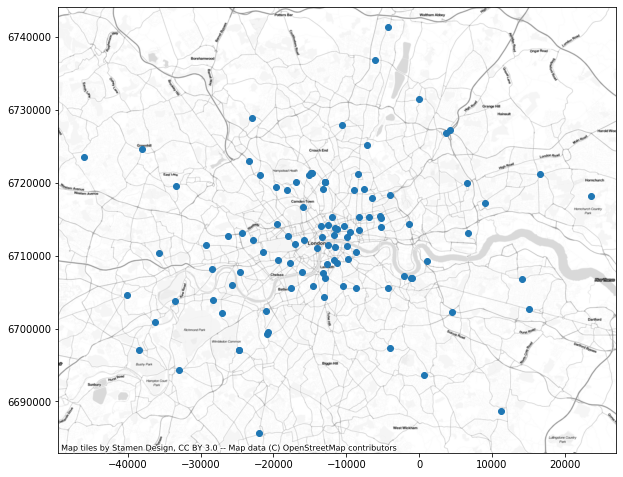

In [7]:
ax=gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

In [8]:
#loading gis road network
path = "/Users/oliverpaul/Data_Science/EDF/LAEI GIS - traffic/SHP/LAEI2016_AADT_VKM_toid.shp"
roads = gpd.read_file(path)
df['Site_Type'] = df['Site_Type'].fillna(0)
roads['VKMTOTAL16'] = roads['VKMTOTAL16'].str.replace(',', '')
roads['VKMTOTAL16'] = roads['VKMTOTAL16'].replace('-', np.nan)

In [9]:
roads['VKMTOTAL16'] = pd.to_numeric(roads['VKMTOTAL16'], errors='coerce')
roads = roads.dropna(subset=['VKMTOTAL16'])
roads['VKMTOTAL16'] = roads['VKMTOTAL16'].astype(int)

In [10]:
#filtering roads dataset for only major roads - motorway or A Road
roads = roads[(roads['DESC_TERM'] == "Motorway") | (roads['DESC_TERM'] == "A Road")]

In [11]:
roads = roads.to_crs({'init': 'epsg:3857'})

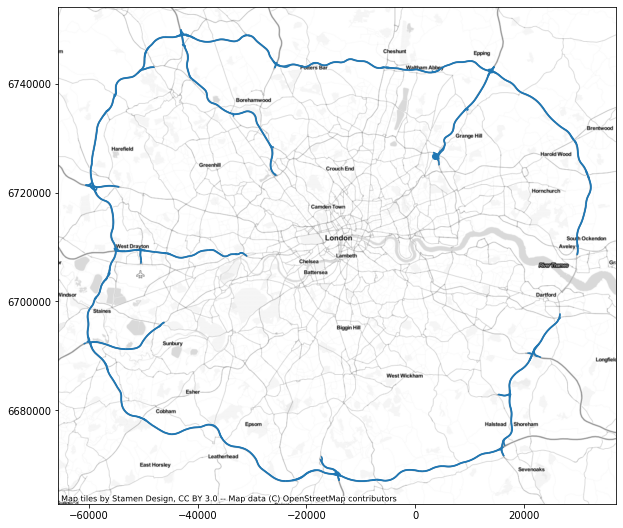

In [28]:
#checking crs my plotting with sensor locations

ax = roads[(roads['DESC_TERM'] == "Motorway")].plot(figsize=(10, 10))
gdf[(gdf['pod_id_location'] == 63245)].plot(ax=ax)
ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

#ax=gdf[(gdf['pod_id_location'] == 63245)].plot(figsize=(20, 20))
#roads[(roads['DESC_TERM'] == "Motorway")].plot(ax=ax, color='red')

#from the below plot we see one school next to motorway and several fairly close 

In [13]:
path = "/Users/oliverpaul/Data_Science/EDF/LAEI - GIS geographies/Ultra_Low_Emissions_Zone.gpkg"
ULEZ = gpd.read_file(path)
crs = {'init': 'epsg:27700'}
ULEZ = gpd.GeoDataFrame(ULEZ, crs=crs)
ULEZ = ULEZ.to_crs({'init': 'epsg:3857'})

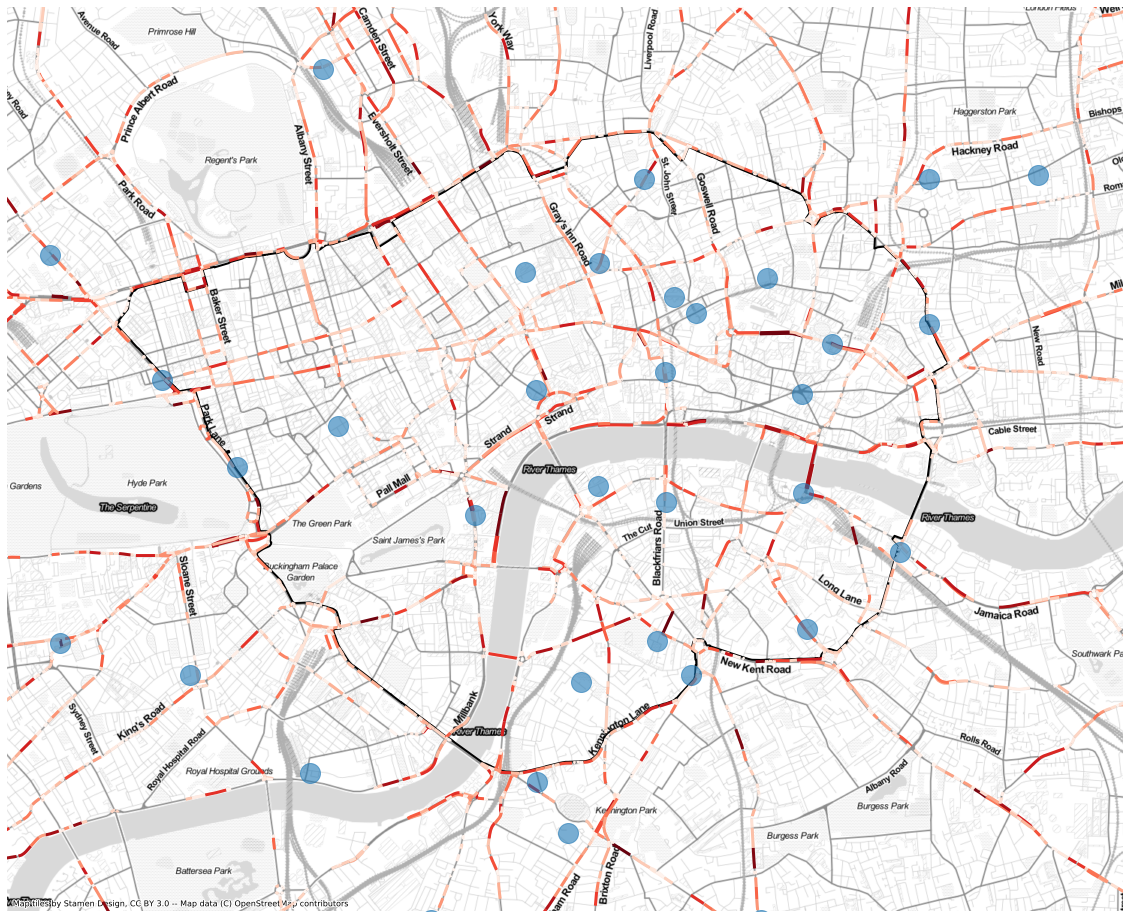

In [26]:
ax = ULEZ.plot(figsize=(20, 20), edgecolor='k', facecolor='none', linewidth=2, zorder = 1)
roads[(roads['DESC_TERM'] == "A Road") & ((roads['VKMTOTAL16'] > 100000) & (roads['VKMTOTAL16'] < 1000000))].plot(ax=ax, 
                                                                               column='VKMTOTAL16', 
                                                                               legend=False, 
                                                                               cmap='Reds', 
                                                                               linewidth = 3, zorder = 5)

gdf.plot(ax=ax, markersize = 400, zorder = 50, alpha = 0.6)

ax.set(xlim=(-20000, -5800), ylim=(6706000, 6717500))
ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)
plt.axis('off')
plt.show()

In [15]:
gdf['motorway_min_dist'] = gdf.geometry.apply(lambda x: roads[(roads['DESC_TERM'] == "Motorway")].distance(x).min())

In [16]:
gdf['a_road_min_dist'] = gdf.geometry.apply(lambda x: roads[(roads['DESC_TERM'] == "A Road")].distance(x).min())

In [24]:
gdf.to_csv("road_distances.csv")